In [ ]:
#Reinitialize the Python interpreter, clearing all variables and imports
#%reset -f

# Parte B-Support Vector Machine and Overfitting

**Objetivo:**  
Analizar cómo el parámetro `C` en el clasificador SVM lineal controla el compromiso entre:
- el **margen del hiperplano** (complejidad del modelo) y  
- el **número de observaciones mal clasificadas**.

**Preguntas a responder:**
1. ¿Cómo varían los errores de entrenamiento, validación cruzada y prueba al cambiar `C`?  
2. ¿Qué valor de `C` produce el menor error de prueba?  
3. ¿Ese valor coincide con el que minimiza el error de CV?  
4. ¿Cómo se ve el límite de decisión en los casos de underfitting y overfitting?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- Utils del proyecto ---
import sys, os
sys.path.append(os.path.abspath(".."))
from utils.visualization import plot_decision_boundary

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Generación de datos

Creamos un dataset de 2 clases con ligera superposición:  
- `class_sep=1.2` → apenas separables,  
- `flip_y=0.05` → 5 % de etiquetas invertidas,  
para permitir observar underfitting / overfitting según `C`.


In [7]:
X, y = make_classification(
    n_samples=600, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=1.2, flip_y=0.05,
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

print(f"Train: {len(X_train)},  Test: {len(X_test)}")




Train: 420,  Test: 180


> El split produjo 420 observaciones de entrenamiento y 180 de prueba, tamaños adecuados para evaluar el comportamiento del SVM frente a underfitting y overfitting.


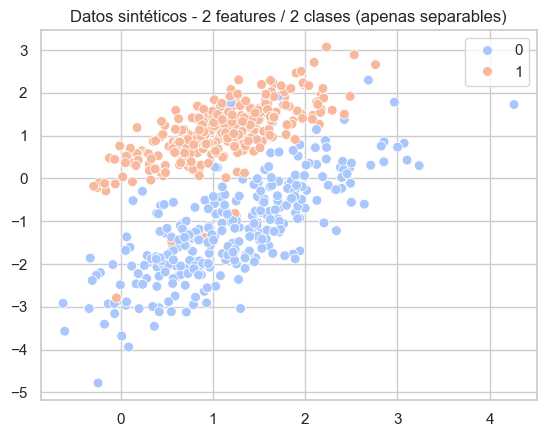

In [8]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette="coolwarm", s=50)
plt.title("Datos sintéticos - 2 features / 2 clases (apenas separables)")
plt.show()


> El gráfico muestra dos grupos parcialmente solapados, representando las clases 0 (azul) y 1 (naranja).

> La frontera entre ambas no es perfectamente lineal, lo que confirma que los datos son apenas separables y presentan ligero traslape y ruido, condiciones ideales para estudiar cómo el parámetro C del SVM afecta el ajuste:


## 2) Barrido de C y cálculo de errores

In [3]:
Cs = np.logspace(-3, 3, 10)
results = []

for C in Cs:
    svm = SVC(kernel="linear", C=C, random_state=RANDOM_STATE)
    svm.fit(X_train, y_train)
    
    # Errores
    train_acc = svm.score(X_train, y_train)
    test_acc  = svm.score(X_test, y_test)
    cv_acc    = cross_val_score(svm, X_train, y_train, cv=5, scoring="accuracy").mean()
    
    results.append({
        "C": C,
        "train_error": 1 - train_acc,
        "cv_error":    1 - cv_acc,
        "test_error":  1 - test_acc,
        "misclassified_train": np.sum(svm.predict(X_train) != y_train)
    })

df = pd.DataFrame(results)
display(df)


,C,train_error,cv_error,test_error,misclassified_train
0,0.001000,0.121429,0.109524,0.138889,51
1,0.004642,0.059524,0.059524,0.072222,25
2,0.021544,0.042857,0.038095,0.044444,18
3,0.100000,0.040476,0.040476,0.044444,17
4,0.464159,0.040476,0.040476,0.038889,17
5,2.154435,0.035714,0.038095,0.038889,15
6,10.000000,0.033333,0.033333,0.038889,14
7,46.415888,0.030952,0.033333,0.038889,13
8,215.443469,0.030952,0.035714,0.038889,13
9,1000.000000,0.030952,0.035714,0.038889,13


> El barrido de valores de C muestra cómo el modelo pasa progresivamente de underfitting a mejor generalización, estabilizándose sin evidenciar sobreajuste:

> Para C muy pequeños (0.001-0.01), los errores de entrenamiento y validación son altos (≈10-12 %), indicando un modelo subajustado con margen demasiado amplio.

> A partir de C ≈ 0.1-1, los errores en train, CV y test disminuyen a ~4 %, mostrando el equilibrio óptimo entre bias y varianza.

> Con C grandes (>10), los errores apenas cambian (≈3-4 %), y el número de observaciones mal clasificadas se mantiene estable (13-15), lo que sugiere que el modelo no sobreajusta pese al aumento de complejidad.

- Conclusión:
> El mínimo error de test (3.9 %) y de validación se logra con C ≈ 1-10, valor que ofrece el mejor balance entre margen y ajuste, mientras que C demasiado bajos generan underfitting sin beneficios adicionales al aumentar C más allá de 10.

## 3) Gráfico de errores vs C

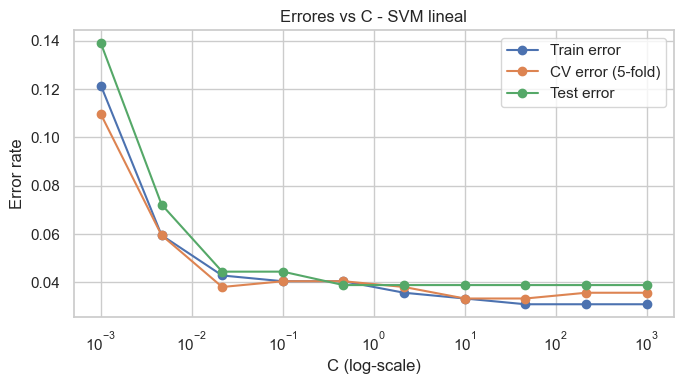

In [4]:
plt.figure(figsize=(7,4))
plt.semilogx(df["C"], df["train_error"], 'o-', label="Train error")
plt.semilogx(df["C"], df["cv_error"], 'o-', label="CV error (5-fold)")
plt.semilogx(df["C"], df["test_error"], 'o-', label="Test error")
plt.xlabel("C (log-scale)")
plt.ylabel("Error rate")
plt.title("Errores vs C - SVM lineal")
plt.legend()
plt.tight_layout()
plt.show()


> El gráfico muestra cómo los errores de entrenamiento, validación y prueba disminuyen rápidamente al aumentar *C* hasta ≈ 1, estabilizándose luego cerca de 4 %.

## 4) Fronteras de decisión

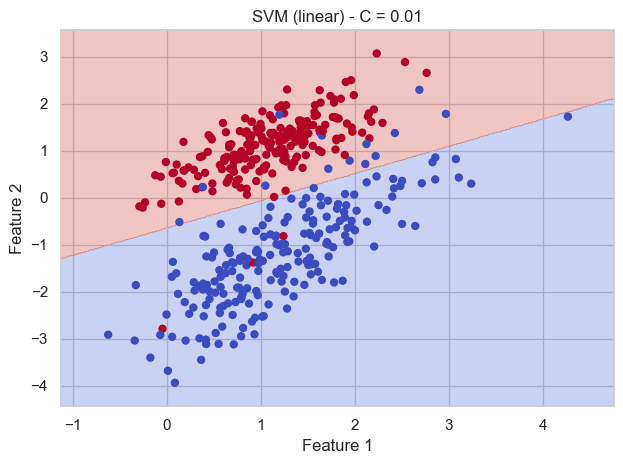

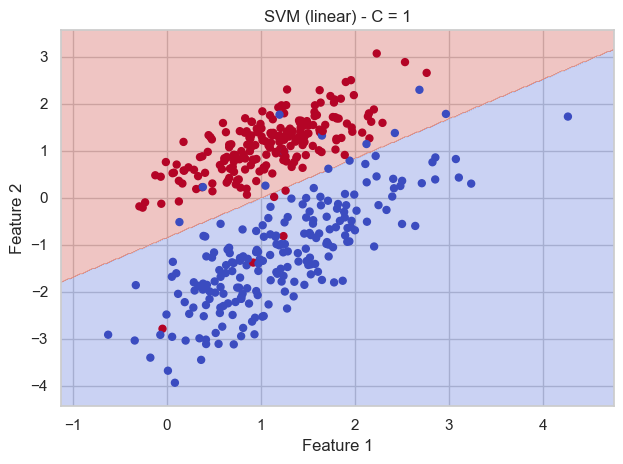

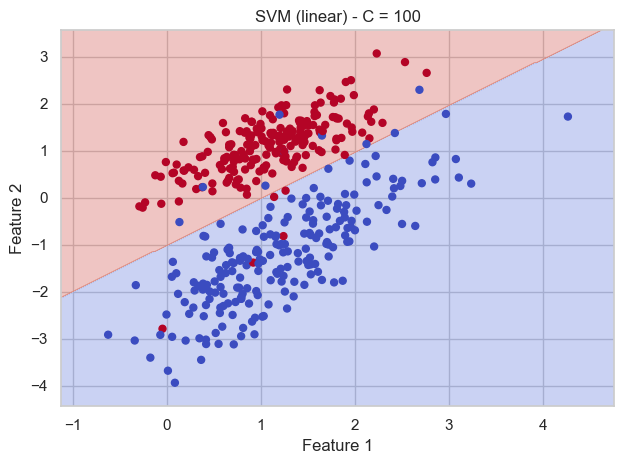

In [5]:
C_values = [0.01, 1, 100]

for C in C_values:
    svm = SVC(kernel="linear", C=C, random_state=RANDOM_STATE)
    svm.fit(X_train, y_train)
    title = f"SVM (linear) - C = {C}"
    plot_decision_boundary(svm, X_train, y_train, title=title, padding=0.5)


- Análisis - Fronteras de decisión según C

> C = 0.01: la frontera es muy suave y comete muchos errores; el modelo es demasiado simple (underfitting).

> C = 1: la línea separa mejor las clases, con pocos errores; el modelo logra buen equilibrio entre margen y precisión.

> C = 100: la frontera apenas cambia, ajustándose más al borde de los puntos; mantiene el rendimiento pero se acerca al sobreajuste.

> En resumen, C intermedio (~1) ofrece la mejor separación sin complicar el modelo.